In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
T_infty = 20.
T_i = 20.
T_b = 20.
T_t = 200.

L_x = 1.0
L_y = 1.0
rho = 1000.
c = 100.
h = 200.
k = 20.
alpha = k/(rho*c)

T_infty = 0.
T_i = 0.
T_b = 0.
T_t = 1.

h = 1.
k = 1.

BC_numbers = [400, 100, 400, 100]      # Order: right, left
n_BC_cum = [np.sum(BC_numbers[0:(i+1)]) for i in range(4)]
print(n_BC_cum)
GOV_number = 10

[400, 500, 900, 1000]


In [3]:
layer_nodes = 100

nn_heat = nn.Sequential( 
    nn.Linear(2, layer_nodes), nn.Sigmoid(), 
    nn.Linear(layer_nodes, layer_nodes, bias=True), nn.Sigmoid(), 
    nn.Linear(layer_nodes, layer_nodes, bias=True), nn.Sigmoid(), 
    nn.Linear(layer_nodes, layer_nodes, bias=True), nn.Sigmoid(), 
    nn.Linear(layer_nodes, layer_nodes, bias=True), nn.Sigmoid(), 
    nn.Linear(layer_nodes, layer_nodes, bias=True), nn.Sigmoid(), 
    nn.Linear(layer_nodes, 1, bias=False)
).to(device)

In [4]:
"""
getTemperature = lambda X: (L_y - X[:, 1:2])*X[:, 1:2]*nn_heat(X) + \
    X[:, 1:2]*(T_t-T_b) + T_b
"""


# f = lambda lapT, Tt: torch.mean(1./alpha*Tt - lapT)     # Residual for the GOV

square_mean  = lambda ts: torch.mean(ts**2)
square_max = lambda ts: torch.max(ts**2)

def grad(outputs, inputs):
    """
    This is useful for taking derivatives
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), 
        create_graph=True)[0]

def laplacian(field_value, X):
    gradV = grad(field_value, X)
    Vxx = grad(gradV[:, 0], X)[:, 0]
    Vyy = grad(gradV[:, 1], X)[:, 1]
    return Vxx+Vyy

# The loss function
def loss(X, i):
    X.requires_grad = True
    field_value = nn_heat(X)
    # print(field_value)
    # The laplacian of the field_value
    gradT = grad(field_value, X)
    lapT = laplacian(field_value, X)
    res1 = square_mean(lapT)

    # Top BC:
    BC_value = field_value[0:n_BC_cum[0], :]
    res2 = square_mean((BC_value-T_t)/(T_t-T_b))

    # Right BC:
    BC_value = field_value[n_BC_cum[0]:n_BC_cum[1], :]
    BC_Tx = gradT[n_BC_cum[0]:n_BC_cum[1], 0]
    h_convec = h*(BC_value-T_infty)
    res3 = square_mean((h_convec+k*BC_Tx)/(h*(T_t-T_infty))**2)

    # Buttom BC:
    BC_value = field_value[n_BC_cum[1]:n_BC_cum[2], :]
    res4 = square_mean((BC_value-T_b)/(T_t-T_b))

    # Left BC:
    BC_value = field_value[n_BC_cum[2]:n_BC_cum[3], :]
    BC_Tx = gradT[n_BC_cum[2]:n_BC_cum[3], 0]
    h_convec = h*(T_infty-BC_value)
    res5 = square_mean((h_convec+k*BC_Tx)/(h*(T_t-T_infty))**2)

    
    if i%100==99:
        print(
            round(res1.item(), 3),
            round(res2.item(), 3),
            round(res3.item(), 3),
            round(res4.item(), 3),
            round(res5.item(), 3),
        )

    return res1+res2+res3+res4+res5


In [5]:
adam = torch.optim.Adam(nn_heat.parameters(), lr=1e-4)

to1 = lambda ts: torch.sin(ts*torch.pi/2)
to0 = lambda ts: -torch.sin(ts*torch.pi/2) + 1.0

n_batch = n_BC_cum[3] + GOV_number

max_it = 5000

for i in range(max_it):
    X = torch.rand(n_batch, 2).to(device)

    # Top
    X[0:n_BC_cum[0], 1] = 1.

    # Right
    X[n_BC_cum[0]:n_BC_cum[1], 0] = 1.
    
    # Buttom
    X[n_BC_cum[1]:n_BC_cum[2], 1] = 0.

    # Left
    X[n_BC_cum[2]:n_BC_cum[3], 0] = 0.

    adam.zero_grad()
    l = loss(X, i)
    l.backward()
    adam.step()
    if i%100==99:
        print(i+1, l)

0.0 0.564 0.062 0.062 0.062
100 tensor(0.7500, device='cuda:0', grad_fn=<AddBackward0>)
0.0 0.562 0.062 0.062 0.062
200 tensor(0.7499, device='cuda:0', grad_fn=<AddBackward0>)
0.0 0.562 0.062 0.062 0.062
300 tensor(0.7498, device='cuda:0', grad_fn=<AddBackward0>)
0.0 0.562 0.062 0.062 0.062
400 tensor(0.7494, device='cuda:0', grad_fn=<AddBackward0>)
0.0 0.56 0.062 0.061 0.062
500 tensor(0.7456, device='cuda:0', grad_fn=<AddBackward0>)
0.016 0.48 0.059 0.035 0.054
600 tensor(0.6436, device='cuda:0', grad_fn=<AddBackward0>)
0.082 0.261 0.059 0.007 0.063
700 tensor(0.4719, device='cuda:0', grad_fn=<AddBackward0>)
0.05 0.182 0.077 0.0 0.07
800 tensor(0.3788, device='cuda:0', grad_fn=<AddBackward0>)
0.009 0.112 0.08 0.009 0.077
900 tensor(0.2876, device='cuda:0', grad_fn=<AddBackward0>)
0.009 0.078 0.097 0.008 0.102
1000 tensor(0.2940, device='cuda:0', grad_fn=<AddBackward0>)
0.008 0.073 0.093 0.007 0.096
1100 tensor(0.2774, device='cuda:0', grad_fn=<AddBackward0>)
0.006 0.07 0.078 0.008 0.

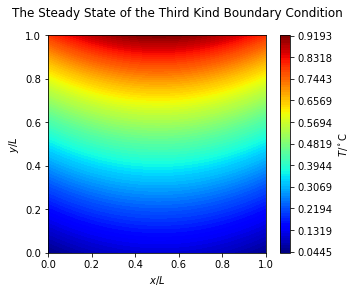

In [6]:
xt_plot = torch.linspace(0, 1, 100)
yt_plot = torch.linspace(0, 1, 100)
[xt_plot, yt_plot] = torch.meshgrid(xt_plot, yt_plot, indexing="ij")
X = torch.cat((xt_plot.reshape(-1)[:, None], yt_plot.reshape(-1)[:, None]), axis=1).to(device)
T = nn_heat(X)
xt_plot = X[:, 0].reshape(100, 100).cpu().detach().numpy()
yt_plot = X[:, 1].reshape(100, 100).cpu().detach().numpy()
T = T.reshape(100, 100).cpu().detach().numpy()

from matplotlib import cm
fig = plt.figure(figsize=(5, 4))
fig.suptitle("The Steady State of the Third Kind Boundary Condition")
ax = fig.add_subplot(111)
cs = ax.contourf(xt_plot, yt_plot, T, 100, cmap=cm.jet)
colorbar = fig.colorbar(cs)
colorbar.set_ticks(np.linspace(np.min(T), np.max(T), 11))
colorbar.set_label(r'$T/\mathrm{^\circ C}$')
"""
More information about colorbar can be found at the official documentation.
I've been bordered with this problem for a long time. It is very helpful!!!
https://matplotlib.org/3.5.0/api/colorbar_api.html#matplotlib.colorbar.Colorbar
"""

ax = plt.gca()
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$y/L$')
ax.set_aspect(1)